In [5]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import copy
import random
from ucimlrepo import fetch_ucirepo 

In [7]:
# helper methods
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

def calculate_diameter(points):
    diameter = 0.0
    num_points = len(points)
    for i in range(num_points):
        for j in range(i+1, num_points):
            distance = euclidean_distance(points[i], points[j])
            if distance > diameter:
                diameter = distance
    return diameter

In [8]:
def offline_k_center(points, k):
    # Initialize the first center randomly
    centers = [points[np.random.randint(len(points))]]
    
    while len(centers) < k:
        # Find the point that is the farthest from any center
        next_center = max(points, key=lambda point: min(euclidean_distance(point, center) for center in centers))
        centers.append(next_center)
    
    return centers

def max_distance_to_centers(points, centers):
    max_dist = 0
    for point in points:
        min_dist_to_center = min(euclidean_distance(point, center) for center in centers)
        max_dist = max(max_dist, min_dist_to_center)
    return max_dist

def plot_points_and_centers(points, centers):
    plt.figure(figsize=(8, 6))
    x, y = zip(*points)
    cx, cy = zip(*centers)
    
    plt.scatter(x, y, color='blue', label='Points')
    plt.scatter(cx, cy, color='red', s=100, label='Centers', edgecolors='black')
    plt.title("Offline k-Center Clustering")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
# setting parameters needed for online algorithm
beta = 1.5

epsilon = 0.25

In [12]:
# initialization for online_k_center
def initialization(points):
    x = np.zeros(len(points))

    # start with a set of candidate points of randomly selected 10 points from input
    #indices = np.random.choice(points.shape[0], size = 10, replace=False)
    #candidates = points[indices, :]
    
    print("\n")
    #print("candidate indices:", indices)
    #print("center candidates:", candidates)

    indices = []
    candidates = []

    # initialize constraint matrix
    constraint_matrix = []

    return x, indices, candidates, constraint_matrix

# update the covering constraints to accommodate insertion and deletion of clients
def update_constraints(C,s, n):
    # update the constraint matrix that for each client, Cx >= 1
    # where row t in C for client t has 0s at entries in s
    new_row = np.zeros(n)
    new_row[s] = 1
    C.append(new_row)
    
    return C

# find all points within the radius of the current client
# this step can be thought of as updating the covering constraint
def find_candidates(candidate_indices, points, client, radius):
    s = []
    for index in candidate_indices:
        #print("index in candidate_indicies:", index)
        if euclidean_distance(points[int(index)], client) <= radius:
            s.append(int(index))
    
    print("candidates within radius:", s)
    return s

# check if new client's constraint is satisfied
def check_covering_feasibility(s, x):
    # check if the covering constraint is satisfied
    covering_sum = np.sum(x[s])
    print("total weight in radius:", covering_sum)
    if covering_sum >= 1:
        return True
    else:
        return False


# covering objective function for solving x's
def covering_objective(x, x_old, s, epsilon):

    # we only deal with the x_i's whose coefficient c_i is nonzero
    prev_x_hat = np.zeros(len(s))

    for i in range(len(prev_x_hat)):
        prev_x_hat[i] = x_old[s[i]] + epsilon/(4*len(s))
    
    #prev_x = np.zeros(len(s))
    return np.sum((x + epsilon/(4*len(s))) * np.log((x + epsilon/(4*len(s)))/prev_x_hat) - (x + epsilon/(4*len(s))))


# packing objective function for solving x's
def packing_objective(x, x_old):

    # avoiding divide by zero
    c = 1e-10
    x_old = np.maximum(x_old, c)
    
    return np.sum(x * np.log(x/x_old) - x)


# covering constraint for solving x's
def covering_constraint(x):
    return np.sum(x) - 1


# packing constraint for solving x's
def packing_constraint(x, epsilon, k):
    return (1 + epsilon) * k - np.sum(x) 


# optimize and update the values of x's when a covering constraint not satisfied
def update_covering_variables(x, s, epsilon):
    # start with x's at t-1
    x0 = np.zeros(len(s))
    for i in range(len(s)):
        x0[i] = x[s[i]]

    # set up constraint for scipy solver for x's
    cons = {'type': 'ineq', 'fun':covering_constraint}

    result = minimize(covering_objective, x0, args=(x, s, epsilon), constraints=cons, method='SLSQP')

    print("updated fractional solutions:", result.x)
    
    # finally, update the values in the original x vector
    x_new = x
    for i in range(len(s)):
        x_new[s[i]] = result.x[i]

    return x_new


# optimize and update the values of x's when a packing constraint not satisfied
def update_packing_variables(x, epsilon, k):
    
    cons = {'type': 'ineq', 'fun':packing_constraint, 'args':(epsilon, k)}

    x0 = x

    result = minimize(packing_objective, x0, args=(x), constraints=cons, method='SLSQP')

    print("updated fraction solutions after packing violation:", result.x)

    return result.x

In [13]:
# set the parameters for rounding
alpha = 3 + 2 * np.sqrt(2)
delta = np.sqrt(2)

In [19]:
# subroutine to find the balls B_i and B_hait_i for a given center_index
# this subroutine is called whenever the set S is updated
def find_balls(data_points, clients, center_index, radius, radius_hat):

    print("inside find_ball function")
    B_i = []
    B_i_hat =[]

    for i in range(len(clients)):
        #print("current client:", j)
        #print("current center:", s[i])

        #print("client coordinate:", data_points[j])
        #print("center coordinate:", data_points[s[i]])
        #print("distance:", euclidean_distance(data_points[j], data_points[s[i]]))
        client_coordinate = clients[i][1]
        client_index = clients[i][0]
        print("distance between client and center:", euclidean_distance(client_coordinate, data_points[center_index]))
        if euclidean_distance(client_coordinate, data_points[center_index]) <= radius:
            B_i.append(client_index)
            
        if euclidean_distance(client_coordinate, data_points[center_index]) <= radius_hat:
            B_i_hat.append(client_index)

    print("points in B_i:", B_i)
    print("points in B_i_hat:", B_i_hat)
    
    return B_i, B_i_hat

In [20]:
def online_k_center(points, k):

    recourse = 0

    # initialize the vector x with all 0s of dimension len(points)
    x, candidate_index, candidates, constraint_mat = initialization(points)

    # store each client as a tuple (index in points, coordinates)
    clients = []
    # the coordinates of active clients
    client_points = []
    client_indices = []

    set_of_centers = []
    radius_of_centers = np.zeros(len(x))


    for t in range(len(points)):

        x_old = copy.deepcopy(x)
        
        # at each iteration if the request is an insertion,
        # add new client to the set of points that are known 
        candidate_index = np.append(candidate_index, int(t))
        candidates = np.append(candidates, points[t])

        # variables for rounding
        current_client = (t, points[t])
        clients.append(current_client)
        client_points.append(points[t])
        client_indices.append(t)

        print("\n")
        
        print("time t:", t)

        print("current client:", points[t])

        # search for points within the radius of the current client
        # the radius at each t is defined as: min(diam(t), beta * OPT(t))
        diam = calculate_diameter(client_points)
        centers_offline = offline_k_center(client_points, k)
        current_OPT_dist = max_distance_to_centers(client_points, centers_offline)

        print("diam(t):", diam)
        print("curront_OPT(t):", current_OPT_dist)

        s = find_candidates(candidate_index, points, points[t], min(beta * current_OPT_dist, diam))
        # update the covering constraint matrix
        #constraint_mat = update_constraints(constraint_mat, s, len(points))

        # check if covering constraint is violated
        # if so, update the values of x's
        print("covering feasibility?", check_covering_feasibility(s, x))
        if check_covering_feasibility(s, x) == False:
            # covering constraint not satisfied, need to update values of x's in s
            x_new = update_covering_variables(x, s, epsilon)

        # check if packing constraint is violated
        # if so, update the values of x's
        if (np.sum(x) > (1+epsilon) * k):
            print("packing constraint violated!")
            x_new = update_packing_variables(x, epsilon, k)

        
        # update total recourse in l1-norm
        print("recourse in this round:", np.sum(np.abs(x_new - x_old)))

        recourse += np.sum(np.abs(x_new - x_old))
        x = x_new

        
        #################################### rounding procedure begins from here ####################################
        # integrate rounding at each round
        # maintain a set S of open centers at each t
        # calculate for each i in S it's radius = min(beta * OPT(t_i), diag)
        # OPT(t_i) is calculated using the offline algorithm

        # calculate OPT_offline for current active clients
        #centers_offline = offline_k_center(client_points, k)
        #current_OPT_dist = max_distance_to_centers(client_points, centers_offline)
        # diam = calculate_diameter(client_points)
        
        # identify the balls/set of points that are B_i and B_i_hat for each i in set_of_centers
        # while building the balls B_i, drop any i from set_of_centers if it has mass less than 1-epsilon
        #list_of_B_i = []

        print("\n")
        print("Rounding begins")
        print("current set of centers:", set_of_centers)

        #list_of_B_i = []
        list_of_B_i_hat = []
        S = copy.deepcopy(set_of_centers)
        for center in S:
            
            print("\n")
            print("for center:", center)
            print("r_i of this center:", radius_of_centers[center])
            print("r_i_hat of this center:", alpha * min(beta * current_OPT_dist, diam))
            
            B_i, B_i_hat = find_balls(points, clients, center, radius_of_centers[center], alpha * min(beta * current_OPT_dist, diam))
            
            # drop any B_i whose mass is too small
            mass = 0
            for index_of_point in B_i:
                mass += x[index_of_point]
            
            print("mass for cent", mass)

            if mass < 1 - epsilon:
                set_of_centers.remove(center)
                print("center dropped from set")
            else:
                list_of_B_i_hat.append(B_i_hat)
        
        covered_points = set(item for sublist in list_of_B_i_hat for item in sublist)
        print("\n")
        print("covered points:", covered_points)
        print("all clients:", client_indices)
        while len(covered_points) < len(client_indices):
        # find the clients that are not covered by the current set of centers
            uncovered = set(client_indices) - covered_points
            print("uncovered clients:", uncovered)

            j = next(iter(uncovered))
            set_of_centers.append(j)
            #ball_set.append(j)
            # record current_radius
            current_r = min(beta * current_OPT_dist, diam)
            radius_of_centers[j] = current_r

            print("new center {j} added to set", j)

            for center_index in set_of_centers:
                
                ball_dist = radius_of_centers[j] + radius_of_centers[center_index] + delta * min(radius_of_centers[j], radius_of_centers[center_index])
                print("distance between two centers:", euclidean_distance(points[center_index], points[j]))
                print("ball disj-radius:", ball_dist)
                if center_index != j and euclidean_distance(points[center_index], points[j]) <= ball_dist:
                    set_of_centers.remove(center_index)
                    print("center {center_index} dropped", center_index)

            # update the the set of B_i_hat
            list_of_B_i_hat = []
            for center in set_of_centers:
                B_i, B_i_hat = find_balls(points, clients, center, radius_of_centers[center], alpha * min(beta * current_OPT_dist, diam))
                # ball_set = set(item for sublist in B_hat for item in sublist)
                list_of_B_i_hat.append(B_i_hat)
            covered_points = set(item for sublist in list_of_B_i_hat for item in sublist)
        
        print("all clients covered!")
        print("selected centers for this round:", set_of_centers)

    return x, recourse, set_of_centers


In [23]:
# fetch dataset 
census_income = fetch_ucirepo(id=20) 
  
# data (as pandas dataframes) 
X = census_income.data.features 
y = census_income.data.targets 
  
# metadata 
# print(census_income.metadata) 
  
# variable information 
print(census_income.variables) 

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

data points: [array([36.36296024, 97.17820827]), array([60.9564334 , 50.26790232]), array([90.75664739, 24.92922291]), array([31.43559811, 50.85706912]), array([89.25589985, 53.93422419]), array([94.29097039, 32.3202932 ]), array([76.07850486, 56.12771976]), array([12.20382348, 49.51769101]), array([23.7637544 , 72.82163486]), array([14.0924225 , 80.21969808]), array([45.60699842, 78.51759614]), array([ 6.5051593 , 94.88855373]), array([32.0780065 , 18.65185104]), array([33.9029791 , 34.92095746]), array([22.79351625, 42.71077886]), array([ 9.31027678, 89.7215758 ]), array([60.75448519, 17.05241237]), array([68.42330265, 44.01524937]), array([30.4242243 , 52.47564316]), array([ 3.14291857, 63.64104113]), array([59.78999788, 92.1874235 ]), array([38.86772897, 27.13490318]), array([31.8003475 , 11.00519245]), array([ 3.43885211, 90.93204021]), array([69.09377381, 38.67353463]), array([22.87981655,  7.69799098]), array([41.0382923 , 75.55511385]), array([96.24472949, 25.17822958]), array(

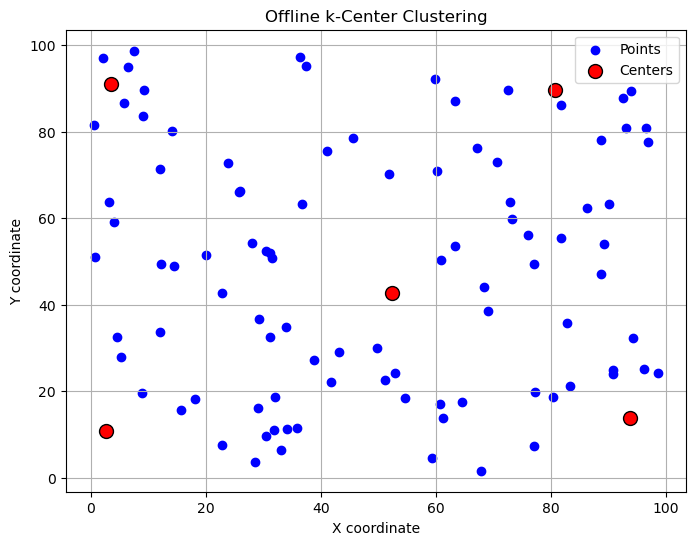

Selected Centers: [array([ 3.43885211, 90.93204021]), array([93.67299887, 13.75209441]), array([ 2.54191267, 10.7891427 ]), array([80.74401552, 89.60912999]), array([52.27328294, 42.75410184])]
Maximum distance to nearest center: 39.95162965065202


In [21]:
## parse inputs
# Generate random points
np.random.seed(42)
all_points = np.random.rand(100, 2) * 100  # 100 points in a 100x100 grid
data_points = random.sample(list(all_points), 100)
print("data points:", data_points)

# Number of centers
k = 5

# Solve the offline k-center problem
centers = offline_k_center(data_points, k)

# Calculate the maximum distance to the nearest center
# This value used as input parameter in the online problem
max_dist = max_distance_to_centers(data_points, centers)

diam_offline = calculate_diameter(data_points)

# Plot the points and the selected centers
plot_points_and_centers(data_points, centers)

print("Selected Centers:", centers)
print("Maximum distance to nearest center:", max_dist)

In [22]:
# begin online algorithm
fractional_sol, recourse, centers = online_k_center(data_points, k) 

print("\n")
print("final fractional solution:", fractional_sol)
print("number of centers:", np.sum(fractional_sol))
print("total recourse:", recourse)
print("final selected centers:", centers)





time t: 0
current client: [36.36296024 97.17820827]
diam(t): 0.0
curront_OPT(t): 0
candidates within radius: [0]
total weight in radius: 0.0
covering feasibility? False
total weight in radius: 0.0
updated fractional solutions: [1.]
recourse in this round: 0.9999999999999988


Rounding begins
current set of centers: []


covered points: set()
all clients: [0]
uncovered clients: {0}
new center {j} added to set 0
distance between two centers: 0.0
ball disj-radius: 0.0
inside find_ball function
distance between client and center: 0.0
points in B_i: [0]
points in B_i_hat: [0]
all clients covered!
selected centers for this round: [0]


time t: 1
current client: [60.9564334  50.26790232]
diam(t): 52.96617530389641
curront_OPT(t): 0
candidates within radius: [1]
total weight in radius: 0.0
covering feasibility? False
total weight in radius: 0.0
updated fractional solutions: [1.]
recourse in this round: 0.9999999999999988


Rounding begins
current set of centers: [0]


for center: 0
r_i of 